# ResNet50 SHAP Partition 분석 테스트

In [3]:
import json
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import shap

c:\Users\USER\anaconda3\envs\ds_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# 사전학습 모델과 데이터 불러오기
model = ResNet50(weights="imagenet")
X, y = shap.datasets.imagenet50()

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


In [ ]:
# ImageNet 1000 클래스 정보 확인
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]
print("Number of ImageNet classes:", len(class_names))
print("class names:", class_names)

Number of ImageNet classes: 1000
class names: ['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead', 'electric_ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house_finch', 'junco', 'indigo_bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water_ouzel', 'kite', 'bald_eagle', 'vulture', 'great_grey_owl', 'European_fire_salamander', 'common_newt', 'eft', 'spotted_salamander', 'axolotl', 'bullfrog', 'tree_frog', 'tailed_frog', 'loggerhead', 'leatherback_turtle', 'mud_turtle', 'terrapin', 'box_turtle', 'banded_gecko', 'common_iguana', 'American_chameleon', 'whiptail', 'agama', 'frilled_lizard', 'alligator_lizard', 'Gila_monster', 'green_lizard', 'African_chameleon', 'Komodo_dragon', 'African_crocodile', 'American_alligator', 'triceratops', 'thunder_snake', 'ringneck_snake', 'hognose_snake', 'green_snake', 'king_snake', 'garter_snake', 'water_snake', 'vine_snake', 'night_snake', 'boa_constrictor', 'rock_python', 'Indian_cobra', 'green_mamba'

In [ ]:
# 모델의 예측 결과(Output)를 가져오는 함수. 모델이 학습한 입력 형식과 일치하도록 전처리 후 모델에 입력
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return model(tmp)

# 픽셀의 기여도를 계산하기 위해 일부 픽셀을 가려서 실험
# 이미지 마스킹 방식 지정
# OpenCV의 inpaint_telea알고리즘 : 특정 부분 제거한 후 보간
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

# SHAP explainer 정의
# f : 예측 함수
# masker : 마스킹 방식
# output_names=class_names : 예측된 클래스의 이름을 할당
explainer = shap.Explainer(f, masker, output_names=class_names)

# 두 개의 미지에 대한 SHAP값 계산
# max_evals=100 : 최대 100번의 평가를 사용
# 가장 중요한 4개의 클래스를 선택
shap_values = explainer(X[1:3], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])

PartitionExplainer explainer: 3it [00:18,  9.18s/it]               


In [23]:
print("shape:", X.shape)

shape: (50, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


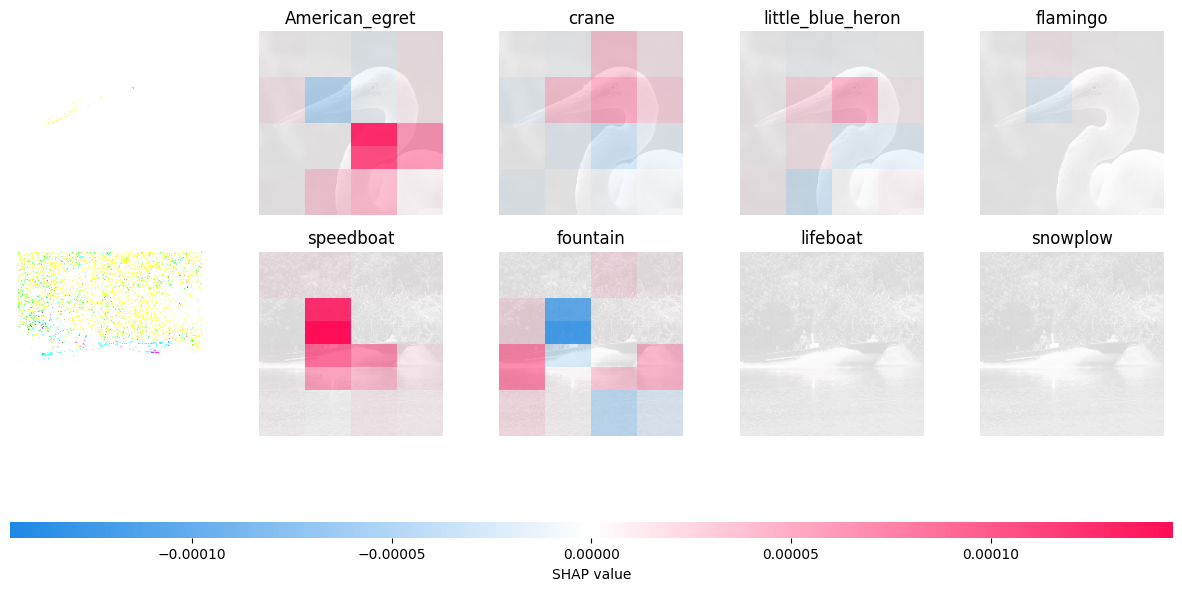

In [18]:
# 예측 결과와 shap 값
shap.image_plot(shap_values)

## evaluations 값 늘리기, masker는 blur(128,128)로 변경

PartitionExplainer explainer: 3it [09:42, 291.38s/it]              
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


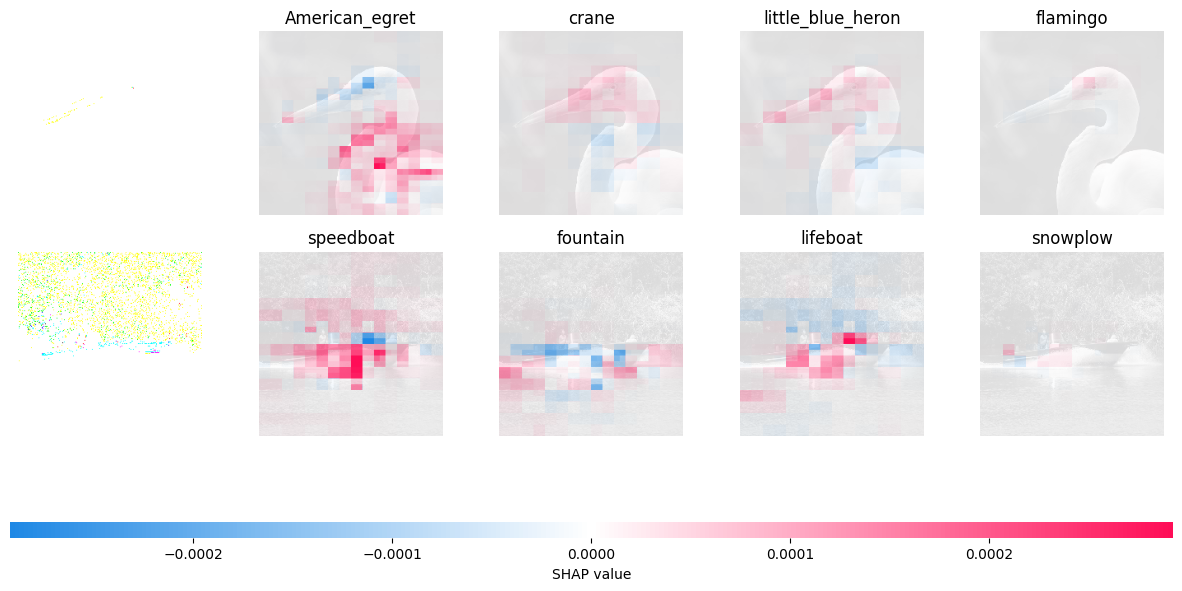

In [24]:
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return model(tmp)

masker_blur = shap.maskers.Image("blur(128,128)", X[0].shape)
explainer_blur = shap.Explainer(f, masker_blur, output_names=class_names)

# max_evals=5000
shap_values_fine = explainer_blur(X[1:3], max_evals=5000, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])

shap.image_plot(shap_values_fine)

# SafeBabyAI ResNet50 모델에 적용

In [27]:
import torch
import torch.nn.functional
import torchvision.models as models
import torchvision.transforms as transforms
import shap
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [28]:
# ResNet50 모델 불러오기
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # GPU 사용시를 상정하여 작성
model = models.resnet50(weights=None) # 가중치 없는 모델
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3) # 클래스 3개
model.load_state_dict(torch.load("best_model.pth", map_location=device)) # 저장된 모델 불러오기기 
model.to(device)
model.eval() # 모델을 평가 모드로 전환

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [29]:
# 모델의 fc레이어 확인 - 클래스 순서 확인을 위해
print(model.fc)

Linear(in_features=2048, out_features=3, bias=True)


In [30]:
# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 이미지 로드 및 변환 함수
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0) # 배치 차원 추가 (1, C, H, W)
    return image_tensor.to(device) # GPU 사용 시를 상정하여 텐서를 특정 장치로 이동시키도록 .to(device)

# 모델 예측 함수
def model_forward(x):
    # SHAP explainer에 입력할 모델 예측 함수
    x_tensor = torch.tensor(x).permute(0, 3, 1, 2).to(device) # (batch, H, W, C) → (batch, C, H, W)
    with torch.no_grad():
        logits = model(x_tensor) # 모델 예측 수행 (logits 값 출력)
        probabilities = F.softmax(logits, dim=1) # 확률 값으로 변환
    return probabilities.cpu().numpy() # numpy 배열로 변환

In [31]:
# SHAP partition explainer 설정

# SHAP 마스킹 방식 설정 (이미지 차원: 224x224, 3)
masker = shap.maskers.Image("inpaint_telea", (224, 224, 3))

# SHAP Explainer 정의
explainer = shap.Explainer(model_forward, masker)

In [39]:
# 분석할 이미지 로드 및 전처리
image_path = r"C:\Users\USER\Desktop\my_git\data-science-experiments\safebaby_ai_model\data\back\back_0032.jpeg" # 분석할 이미지 경로 입력
image_tensor = preprocess_image(image_path).to(device)

# 클래스명 정의
class_name = ["Back", "Front", "Side"]

# 모델 예측 수행
output = model(image_tensor)
probabilities = torch.nn.functional.softmax(output, dim=1) # 확률 변환

# 결과 출력
print("결과 : ", output)
print("예측 확률 :", probabilities)
predicted_class = torch.argmax(probabilities, dim=1).item()
print(f"Predicted Class Index: {predicted_class} -> Class Name: {class_name[predicted_class]}")

결과 :  tensor([[ 1.6698e+00, -2.0444e-03, -2.3215e+00]], grad_fn=<AddmmBackward0>)
예측 확률 : tensor([[0.8289, 0.1558, 0.0153]], grad_fn=<SoftmaxBackward0>)
Predicted Class Index: 0 -> Class Name: Back


변환된 이미지 크기: (224, 224, 3)


PartitionExplainer explainer: 2it [00:24, 24.26s/it]               
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


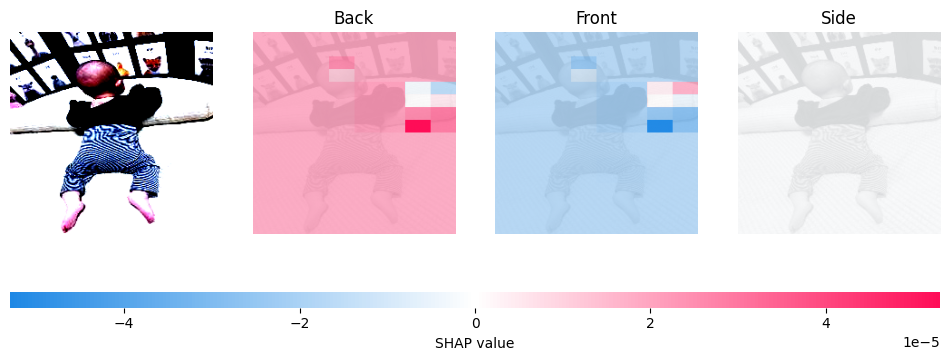

In [40]:
# 올바른 차원 변환 적용 (1, C, H, W, -> H, W, C)
image_numpy = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()

# 차원 확인
print("변환된 이미지 크기:", image_numpy.shape) # (224, 224, 3) 확인

# SHAP 값 계산
shap_values = explainer(np.expand_dims(image_numpy, axis=0), max_evals=500, batch_size=50)

# 시각화
shap.image_plot(shap_values, np.expand_dims(image_numpy, axis=0), labels=class_names)